C:\Users\LGES\AppData\Local\Temp\ipykernel_19440\4211683942.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Out_{i+1}'] = col_out
C:\Users\LGES\AppData\Local\Temp\ipykernel_19440\4211683942.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'In_{i+1}'] = col_in
C:\Users\LGES\AppData\Local\Temp\ipykernel_19440\4211683942.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

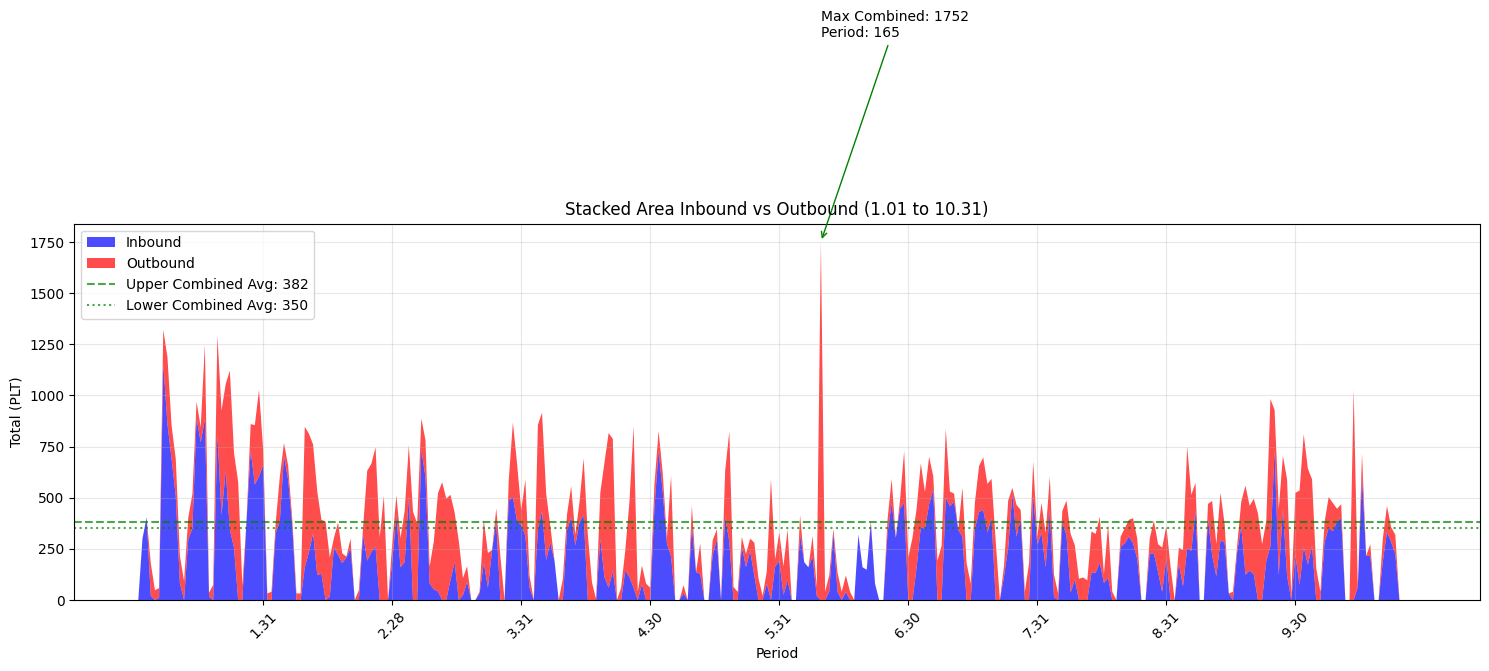

Upper Combined Avg: 382
Lower Combined Avg: 350
Max Combined: 1752 at period 165


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드 및 처리 (1.01 ~ 10.31: 310 기간)
df_raw = pd.read_csv('VMI Stock file.csv', header=None, skiprows=3, sep=',', low_memory=False)
df = pd.DataFrame({'Item': df_raw.iloc[:, 1]})
max_cols = len(df_raw.columns)
num_periods = min(310, (max_cols - 8) // 3)  # 안전한 기간 수 계산
inbound_cols = []
outbound_cols = []
for i in range(num_periods):
    idx_in = 7 + 3 * i
    idx_out = 8 + 3 * i
    if idx_in < max_cols and idx_out < max_cols:
        col_in = pd.to_numeric(df_raw.iloc[:, idx_in].astype(str).str.replace(',', '').str.strip(), errors='coerce').fillna(0)
        col_out = pd.to_numeric(df_raw.iloc[:, idx_out].astype(str).str.replace(',', '').str.strip(), errors='coerce').fillna(0)
        df[f'In_{i+1}'] = col_in
        df[f'Out_{i+1}'] = col_out
    inbound_cols.append(f'In_{i+1}')
    outbound_cols.append(f'Out_{i+1}')

# 청소 및 합산
df = df[df['Item'].astype(str).str.contains('Item|nan', na=False) == False].dropna(subset=['Item'])
item_inbound = df.groupby('Item')[inbound_cols].sum()
item_outbound = df.groupby('Item')[outbound_cols].sum()
total_inbound = item_inbound.sum(axis=0)
total_outbound = item_outbound.sum(axis=0)

# 길이 맞춤 및 Combined 계산 (동일 길이 보장)
min_len = min(len(total_inbound), len(total_outbound))
total_inbound = total_inbound.iloc[:min_len].values  # numpy array로 변환하여 길이 고정
total_outbound = total_outbound.iloc[:min_len].values  # numpy array로 변환하여 길이 고정
total_combined = total_inbound + total_outbound

# 기간
periods = np.arange(1, min_len + 1)

# 상반기/하반기 평균 (1-6월: 186, 7-10월: 124) - Combined
upper_mask = periods <= 186
lower_mask = ~upper_mask  # 길이 맞춤 위해 ~ 사용 (boolean mask)
upper_combined_avg = np.mean(total_combined[upper_mask])
lower_combined_avg = np.mean(total_combined[lower_mask])

# 월말 일자 표시
month_ends = [31, 62, 93, 124, 155, 186, 217, 248, 279, 310]  # 1-based month ends up to 10.31
month_end_labels = ['1.31', '2.28', '3.31', '4.30', '5.31', '6.30', '7.31', '8.31', '9.30', '10.31']
month_ends = [p for p in month_ends if p <= min_len]
month_end_labels = month_end_labels[:len(month_ends)]

# 누적 영역 그래프 (Inbound + Outbound 스택)
fig, ax = plt.subplots(figsize=(15, 8))
ax.stackplot(periods, total_inbound, total_outbound, labels=['Inbound', 'Outbound'], colors=['blue', 'red'], alpha=0.7)

# 평균 직선 (Combined)
ax.axhline(y=upper_combined_avg, color='green', ls='--', alpha=0.7, label=f'Upper Combined Avg: {upper_combined_avg:.0f}')
ax.axhline(y=lower_combined_avg, color='green', ls=':', alpha=0.7, label=f'Lower Combined Avg: {lower_combined_avg:.0f}')

# Max 표시 (Combined Max)
max_combined_idx = np.argmax(total_combined)
ax.annotate(f'Max Combined: {total_combined[max_combined_idx]:.0f}\nPeriod: {periods[max_combined_idx]}', 
            xy=(periods[max_combined_idx], total_combined[max_combined_idx]), 
            xytext=(periods[max_combined_idx], total_combined[max_combined_idx] + 1000),
            arrowprops=dict(arrowstyle='->', color='green'))

ax.set_title('Stacked Area Inbound vs Outbound (1.01 to 10.31)')
ax.set_xlabel('Period')
ax.set_ylabel('Total (PLT)')
ax.set_xticks(month_ends)
ax.set_xticklabels(month_end_labels, rotation=45)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('analysis_stacked_area.png')
plt.show()

print(f'Upper Combined Avg: {upper_combined_avg:.0f}')
print(f'Lower Combined Avg: {lower_combined_avg:.0f}')
print(f'Max Combined: {total_combined.max():.0f} at period {periods[np.argmax(total_combined)]}')